# More volatility

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pytz
import os
import patsy #for spline regression
import scipy #for non-negative least square 
import scipy as sp 
from scipy import stats
from scipy.optimize import nnls
from numpy.linalg import inv #for matrix and statistics
import scipy as sp
import math
import statsmodels.api as sm
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
import sklearn.cluster
import sklearn.linear_model
%matplotlib inline

In [2]:
#specify data source 
datasource = 'LocusEnergy'

In [3]:
#zipcode = '08640'
zipcode = '08641'
#zipcode = '92562'
#zipcode = '92563'

In [4]:
#mainDir = 'C:/Users/umnouyp/Dropbox/Active/EnergyProject/Thesis/PVreadingsStudies/main'
#mainDir = 'C:/Users/Tee/Dropbox/Active/EnergyProject/Thesis/PVreadingsStudies/main'
mainDir = 'C:\Users\Admin\Dropbox\Active\EnergyProject\Thesis\PVreadingsStudies\main'
#we can choose which data to look at.
dataDir = mainDir + '/data/' + datasource +'/' + zipcode +'/'
outputDir = mainDir + '/output/'+ datasource +'/' + zipcode +'/'

In [5]:
data = pd.read_csv(dataDir +'/training_data_fitted.csv')
data['tsLocal'] = data['tsLocal'].map(lambda x: datetime.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))

dsummary = pd.read_csv(outputDir+"/fitsummary.csv")
dsummary.Date = dsummary.Date.map(lambda x: datetime.datetime.strptime(x,"%Y-%m-%d").date())
FullModelCoef = pd.read_csv(outputDir+"/FullModelCoef.csv")

In [6]:
dsummary[:1]

,E,Rsq,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,Date,DBW,singlemax,PeakCheck,FirstCheck,SecondCheck,mE
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-01-01,-355,NaN,False,False,False,4.742651


In [7]:
FullModelCoef[:1]

,DBW,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10
0,0,0.146378,0.415993,0.488299,0.645738,0.714671,0.729269,0.760784,0.76581,0.660012,0.647527,0.141794


Here we define power ratio, $r$, for each power reading. We add shift to avoid infinity.

In [24]:
#shift = 0.01
#data['r'] = (data.power+shift)/(data.mpower+shift)

In [8]:
data[:1]

,tsLocal,altitude,azimuth,power,numactivecomp,totalsize,s,DBW,mpower,r,expectedr
0,2013-01-01 07:30:00,1.11014,-301.362934,NaN,5,64.71819,-0.999743,-355,0.296,NaN,0.415969


## Basic time series construction

Here we construct time series of power and power ratio. We add time without sun to create consistent time series. In addition, we add parallel values of previous 15 minute instances (-1, -2, ...) and previous day instances (y).

In [9]:
#specify scope
StartScopeDate = '2014-01-01'
EndScopeDate = '2015-01-01'
StartScopeTime =  datetime.datetime.strptime(StartScopeDate,"%Y-%m-%d")
EndScopeTime =  datetime.datetime.strptime(EndScopeDate,"%Y-%m-%d")

#Generate data frame from start to end for time series
tslist = []
nxt = StartScopeTime
while nxt < EndScopeTime:
    tslist.append(nxt)
    nxt += datetime.timedelta(minutes=15)
    
Scope = pd.DataFrame(0, index = np.arange(len(tslist)), columns = ['tsLocal'])
Scope['tsLocal'] = tslist

#Now we can merge using Scope Table as a backbone of data structure.
d = pd.merge(Scope,data,on=['tsLocal'], how = 'left') 

# Volatility: Time consideration

Here we look at volatility by hour. Volatility used here is derivated-based volatility.

In [27]:
#select data to analyze
StartDate = datetime.date(2014,1,1)
TestData = d[d.tsLocal.map(lambda x: x.date()) >=StartDate].set_index('tsLocal')
#TestData = d.set_index('tsLocal')
TestDateList = list(set(TestData.index.map(lambda x: x.date())))
#set up date list and summary table
TestDateList.sort()

#Consider every hour from 6 am to 6 pm
VariabilityTable = pd.DataFrame(float('NaN'), index = np.arange(len(TestDateList)), \
                        columns = ['6','7','8','9','10','11','12','13','14','15','16','17','E','mE','V'])
VariabilityTable['Date']=TestDateList

In [28]:
for i in range(0,VariabilityTable.shape[0]):
    DailyData = TestData[TestData.index.map(lambda x: x.date()) == VariabilityTable.Date[i]]
    d_series = DailyData[['power','mpower']].dropna()
    #Daily energy
    VariabilityTable.loc[i,"E"] = DailyData['power'].sum()/60*15
    VariabilityTable.loc[i,"mE"] = DailyData['mpower'].sum()/60*15
    d_series = d_series.reset_index(drop=True)
    #Daily volatility (status-quo)
    l = d_series.loc[range(4,d_series.shape[0]),'power'].reset_index(drop=True) \
            -4*d_series.loc[range(3,d_series.shape[0]-1),'power'].reset_index(drop=True)\
            +6*d_series.loc[range(2,d_series.shape[0]-2),'power'].reset_index(drop=True)\
            -4*d_series.loc[range(1,d_series.shape[0]-3),'power'].reset_index(drop=True)\
            +d_series.loc[range(0,d_series.shape[0]-4),'power']
    VariabilityTable.loc[i,"V"] = np.sum(np.absolute(l))
    #hourly volatility (status-quo)
    for j in range(6,18):
        check = DailyData[DailyData.index.map(lambda x: (x.hour+x.minute/60.>=j)&(x.hour+x.minute/60.<=j+1))]
        if len(check[['power']])==len(check[['power']].dropna()):
            d_series = check[['power']].dropna()
            d_series = d_series.reset_index(drop=True)
            l = d_series.loc[range(4,d_series.shape[0]),'power'].reset_index(drop=True) \
                -4*d_series.loc[range(3,d_series.shape[0]-1),'power'].reset_index(drop=True)\
                +6*d_series.loc[range(2,d_series.shape[0]-2),'power'].reset_index(drop=True)\
                -4*d_series.loc[range(1,d_series.shape[0]-3),'power'].reset_index(drop=True)\
                +d_series.loc[range(0,d_series.shape[0]-4),'power']
            VariabilityTable.loc[i,str(j)] = np.sum(np.absolute(l))

In [29]:
VariabilityTable = VariabilityTable.set_index('Date')

In [30]:
#VariabilityTable_08641 = VariabilityTable
VariabilityTable_92563 = VariabilityTable
#VariabilityTable = VariabilityTable92563

### Distribution of daily volatility in a year

These histograms show distribution of volatilities in a year.

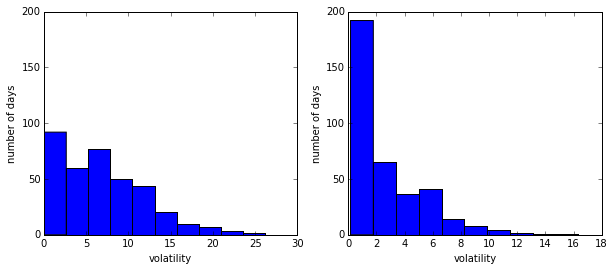

In [31]:
if ('VariabilityTable_08641' in locals()) & ('VariabilityTable_92563' in locals()):
    fig = plt.figure(figsize=(10, 4))
    ax1 = fig.add_subplot(121)
    plt.hist(VariabilityTable_08641['V'])
    plt.ylim(0,200)
    plt.xlabel('volatility')
    plt.ylabel('number of days')
    ax1 = fig.add_subplot(122)
    plt.hist(VariabilityTable_92563['V'])
    plt.ylim(0,200)
    plt.xlabel('volatility')
    plt.ylabel('number of days')

Let's look closely at days with low volatility (10% percentile of combined data) in term of volatility distribution and pecent energy generated

In [35]:
lowV = np.percentile(list(VariabilityTable_08641['V'])+list(VariabilityTable_92563['V']),10)
lowV

0.32775707657375314

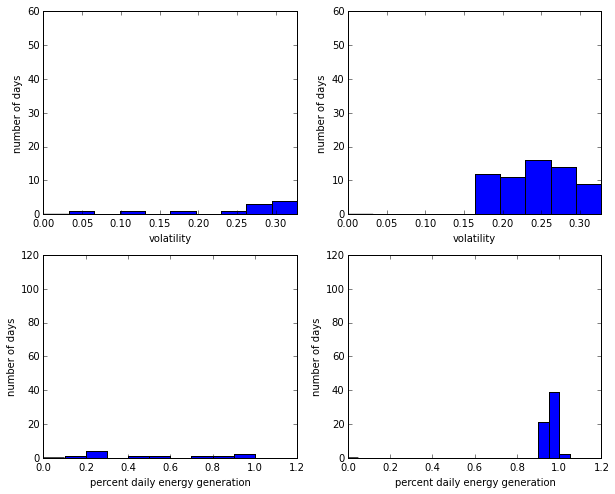

In [37]:
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(221)
plt.hist(VariabilityTable_08641['V'][VariabilityTable_08641['V']<lowV],range=(0,lowV))
plt.xlim(0,lowV)
plt.ylim(0,60)
plt.xlabel('volatility')
plt.ylabel('number of days')
ax1 = fig.add_subplot(222)
plt.hist(VariabilityTable_92563['V'][VariabilityTable_92563['V']<lowV],range=(0,lowV))
plt.xlim(0,lowV)
plt.ylim(0,60)
plt.xlabel('volatility')
plt.ylabel('number of days')
ax1 = fig.add_subplot(223)
l = VariabilityTable_08641['E'][VariabilityTable_08641['V']<lowV]
l = l/VariabilityTable_08641['mE'][VariabilityTable_08641['V']<lowV]
plt.hist(l,range=(0,1.2),bins=12)
plt.xlim(0,1.2)
plt.ylim(0,120)
plt.xlabel('percent daily energy generation')
plt.ylabel('number of days')
ax1 = fig.add_subplot(224)
l = VariabilityTable_92563['E'][VariabilityTable_92563['V']<lowV]
l = l/VariabilityTable_92563['mE'][VariabilityTable_92563['V']<lowV]
plt.hist(l,range=(0,1.2),bins=24)
plt.xlim(0,1.2)
plt.ylim(0,120)
plt.xlabel('percent daily energy generation')
plt.ylabel('number of days')

### Daily volatility over season

Select volatility in an hour over a year, say at noon.

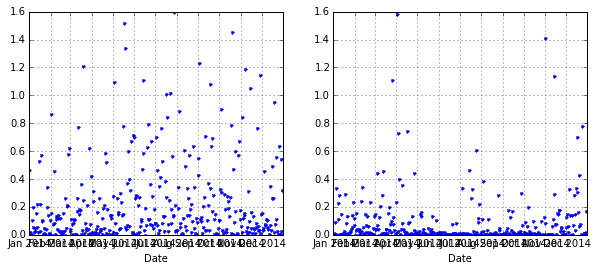

In [38]:
fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(121)
VariabilityTable_08641['12'].plot(style='.')
ax1 = fig.add_subplot(122)
VariabilityTable_92563['12'].plot(style='.')

This may still not be a fair comparison as the power in summer is higher than in winter even in a single hour.

### Hourly volatility over day

Here we plot hourly volatility over critical time of day (8-16) for every 7 days in a year.

(0, 2)

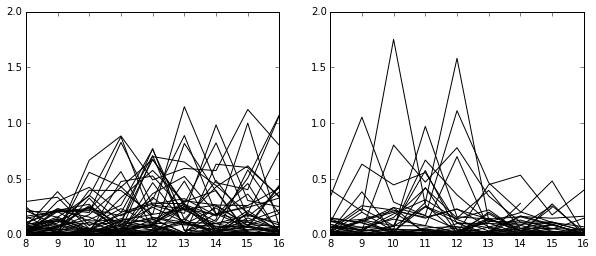

In [41]:
fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(121)
for i in range(0,VariabilityTable_08641.shape[0],7):
    plt.plot(range(8,17),VariabilityTable_08641.iloc[i,range(2,11)],color='black')
plt.ylim(0,2)
ax1 = fig.add_subplot(122)
for i in range(0,VariabilityTable_92563.shape[0],7):
    plt.plot(range(8,17),VariabilityTable_92563.iloc[i,range(2,11)],color='black')
plt.ylim(0,2)

(0, 2)

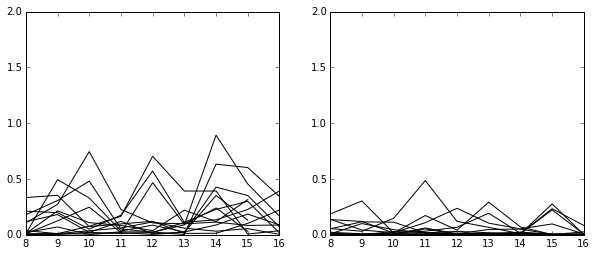

In [42]:
fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(121)
for i in range(0,VariabilityTable_08641.shape[0],30):
    plt.plot(range(8,17),VariabilityTable_08641.iloc[i,range(2,11)],color='black')
plt.ylim(0,2)
ax1 = fig.add_subplot(122)
for i in range(0,VariabilityTable_92563.shape[0],30):
    plt.plot(range(8,17),VariabilityTable_92563.iloc[i,range(2,11)],color='black')
plt.ylim(0,2)

Example

(0, 2)

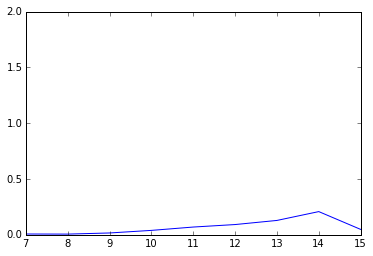

In [44]:
#choose a value of i = 0,..,364
i=2
plt.plot(range(6,18),VariabilityTable.iloc[i,range(0,12)])
plt.ylim(0,2)

Even though hourly volatility is not really smooth, most days have similar level of volatility throughout the day. 

## Examples of High/Low volatility days

In [45]:
#High volatility for 92563
VariabilityTable.loc[datetime.date(2014,12,24),'V']

9.562249766894281

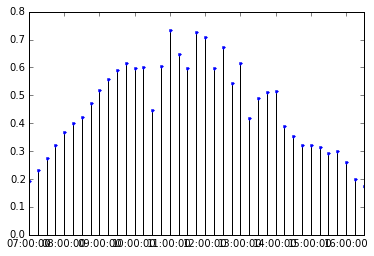

In [46]:
DailyData = TestData[TestData.index.map(lambda x: x.date()) == datetime.date(2014,12,24)]
#Do Linear regression between power and mpower 
d_series = DailyData[['power']].dropna()
#d_series = d_series.reset_index(drop=True)
plt.plot(d_series.index,d_series['power'],'.')
#d_series.plot(ylim=[0,1],style='.')
plt.vlines(x = d_series.index, ymin= 0, ymax = d_series.loc[d_series.index,'power'])

In [47]:
#Low volatility for 92563
VariabilityTable.loc[datetime.date(2014,12,29),'V']

0.21565962657225182

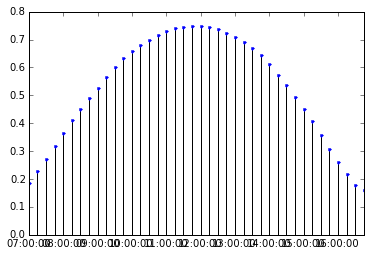

In [48]:
DailyData = TestData[TestData.index.map(lambda x: x.date()) == datetime.date(2014,12,29)]
#Do Linear regression between power and mpower 
d_series = DailyData[['power']].dropna()
#d_series = d_series.reset_index(drop=True)
plt.plot(d_series.index,d_series['power'],'.')
#d_series.plot(ylim=[0,1],style='.')
plt.vlines(x = d_series.index, ymin= 0, ymax = d_series.loc[d_series.index,'power'])

## Quality check of daily volatility

Here we would like to look at clear days (judged by eye) and see how the vollatility looks like. In return, we would like to look at day with low volatilites and see how the power profile looks like.

In [ ]:
#Smooth clear days (judged by eye) for 92563
l = [VariabilityTable.loc[datetime.date(2014,1,11),'V'],
VariabilityTable.loc[datetime.date(2014,1,13),'V'],
VariabilityTable.loc[datetime.date(2014,1,14),'V'],
VariabilityTable.loc[datetime.date(2014,2,1),'V'],
VariabilityTable.loc[datetime.date(2014,2,23),'V'],
VariabilityTable.loc[datetime.date(2014,2,25),'V'],
VariabilityTable.loc[datetime.date(2014,3,10),'V'],
VariabilityTable.loc[datetime.date(2014,3,15),'V'],
VariabilityTable.loc[datetime.date(2014,3,16),'V'],
VariabilityTable.loc[datetime.date(2014,3,31),'V']]
l

In [50]:
np.max(VariabilityTable['V']),np.median(l)

(16.330663647228114, 0.41206419712622078)

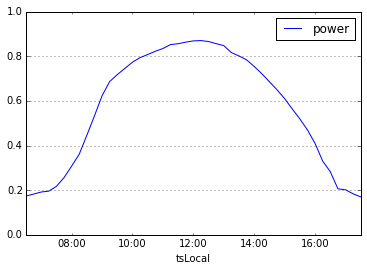

In [51]:
DailyData = TestData[TestData.index.map(lambda x: x.date()) == datetime.date(2014,2,25)]
#DailyData = TestData[TestData.index.map(lambda x: x.date()) == datetime.date(2014,3,10)]
#Do Linear regression between power and mpower 
d_series = DailyData[['power']].dropna()
#d_series = d_series.reset_index(drop=True)
d_series.plot(ylim=[0,1])

In [53]:
VariabilityTable[['V']][VariabilityTable['V']<np.median(l)].shape[0]

97

In [54]:
VariabilityTable[['V','E','12']][VariabilityTable['V']<np.median(l)][:10]

,V,E,12
Date,,,
2014-01-01,0.348447,4.996488,0.007059
2014-01-05,0.232433,5.205489,0.006316
2014-01-13,0.244233,5.370031,0.005502
2014-01-15,0.241963,5.346104,0.013417
2014-01-16,0.326803,5.397464,0.030490
2014-01-17,0.370831,5.381391,0.010000
2014-02-01,0.359720,6.025448,0.001377
2014-02-23,0.193943,6.642623,0.001771
2014-02-24,0.236760,6.612018,0.016077


Among this list, there have smooth profile.

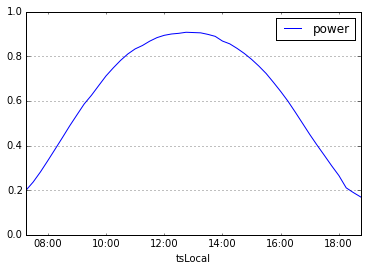

In [55]:
#DailyData = TestData[TestData.index.map(lambda x: x.date()) == datetime.date(2014,1,1)]
DailyData = TestData[TestData.index.map(lambda x: x.date()) == datetime.date(2014,3,14)]
#Do Linear regression between power and mpower 
d_series = DailyData[['power']].dropna()
#d_series = d_series.reset_index(drop=True)
d_series.plot(ylim=[0,1])

## Inter-day volatility: Day-by-Day Comparison

First, let's look at CA.

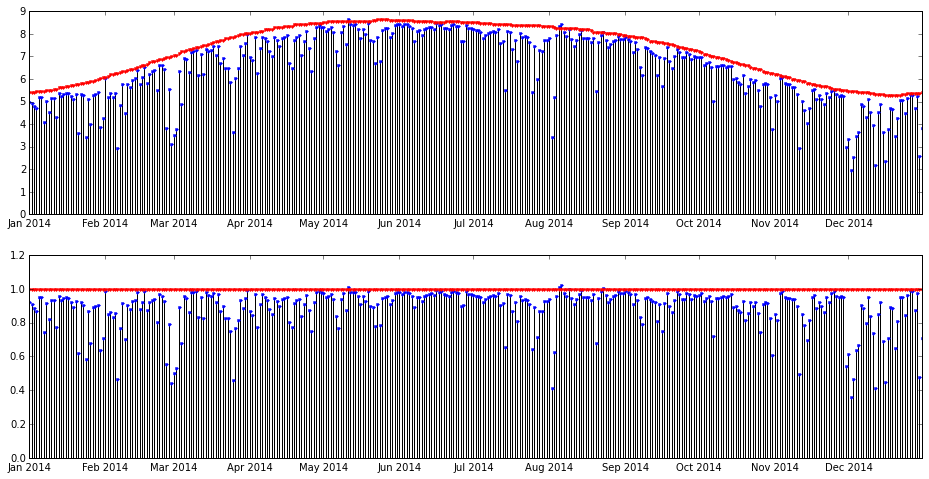

In [57]:
VariabilityTable = VariabilityTable_92563

#plt.plot(VariabilityTable['E'],VariabilityTable['V'],'.')
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(211)
plt.plot(VariabilityTable.index,VariabilityTable['E'],'.')
plt.plot(VariabilityTable.index,VariabilityTable['mE'],'.',color='red')
#d_series.plot(ylim=[0,1],style='.')
plt.vlines(x = VariabilityTable.index, ymin= 0, ymax = VariabilityTable.E)

ax1 = fig.add_subplot(212)
plt.plot(VariabilityTable.index,VariabilityTable['E']/VariabilityTable['mE'],'.')
plt.plot(VariabilityTable.index,VariabilityTable['E']*0+1,'.',color='red')
#d_series.plot(ylim=[0,1],style='.')
plt.vlines(x = VariabilityTable.index, ymin= 0, ymax = VariabilityTable.E/VariabilityTable.mE)

For NJ, we see more points on the low-daily-energy with with higher inter-day volatilty compared to CA.

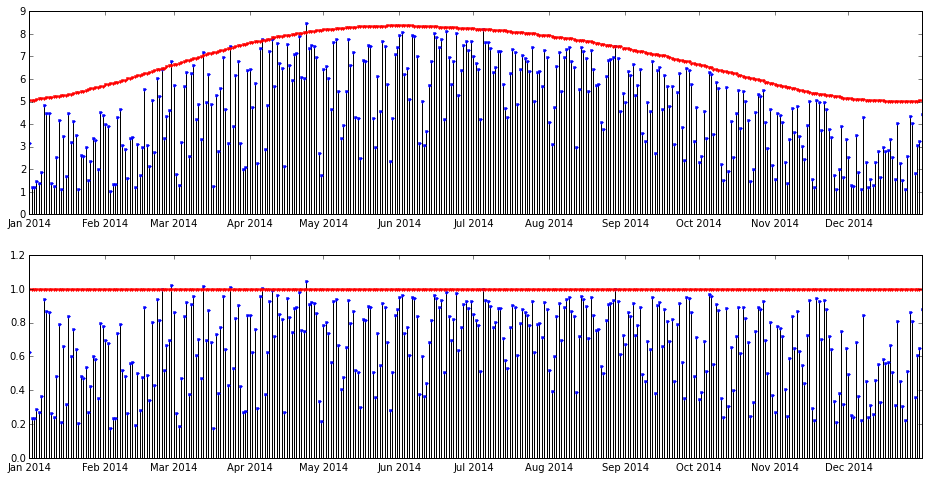

In [58]:
VariabilityTable = VariabilityTable_08641

#plt.plot(VariabilityTable['E'],VariabilityTable['V'],'.')
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(211)
plt.plot(VariabilityTable.index,VariabilityTable['E'],'.')
plt.plot(VariabilityTable.index,VariabilityTable['mE'],'.',color='red')
#d_series.plot(ylim=[0,1],style='.')
plt.vlines(x = VariabilityTable.index, ymin= 0, ymax = VariabilityTable.E)

ax1 = fig.add_subplot(212)
plt.plot(VariabilityTable.index,VariabilityTable['E']/VariabilityTable['mE'],'.')
plt.plot(VariabilityTable.index,VariabilityTable['E']*0+1,'.',color='red')
#d_series.plot(ylim=[0,1],style='.')
plt.vlines(x = VariabilityTable.index, ymin= 0, ymax = VariabilityTable.E/VariabilityTable.mE)